Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [9]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts.clean import clean_dataset
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [37]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
df = clean_dataset(X)

age = [val.left for val in df.age.unique()]
age.sort()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,"(34.0, 41.0]",State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,FullTime,United-States,0
1,"(41.0, 50.0]",Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,PartTime,United-States,0
2,"(34.0, 41.0]",Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,FullTime,United-States,0
3,"(50.0, 90.0]",Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,FullTime,United-States,0
4,"(26.0, 34.0]",Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,FullTime,Cuba,0


## Model training and test

In [11]:
y = df['income']
X = df.drop('income', axis=1)

num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [12]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 4.93 s


array([0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     10205
           1       0.74      0.61      0.67      3362

    accuracy                           0.85     13567
   macro avg       0.81      0.77      0.79     13567
weighted avg       0.84      0.85      0.84     13567



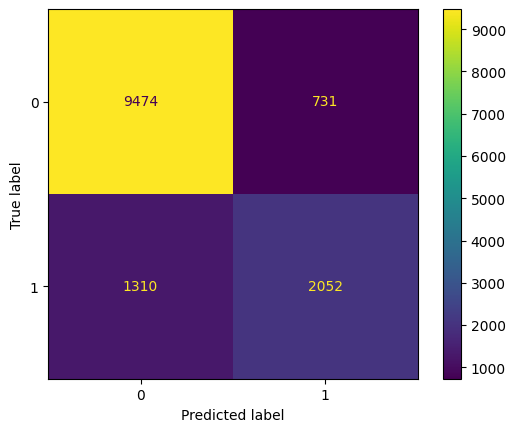

In [14]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [15]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    freqitem_minsupp = 0.08,
    missing_subgroup_val="Unknown",
    drop_infeasible = True,
    drop_above = True
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.


100%|██████████| 852/852 [00:04<00:00, 171.44it/s]

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\dinos\anaconda3\envs\work\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\dinos\AppData\Local\Temp\ipykernel_29924\578203489.py", line 1, in <module>
    ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
  File "C:\Users\dinos\Documents\Εργασία\Counterfactuals\gfacts\gfacts\misc.py", line 191, in valid_ifthens_with_coverage_correctness
    ifthens = [(h, s, ifsupps) for h, ifsupps in tqdm(aff_intersection) for s in freq_unaffected if recIsValid(h, s,drop_infeasible)]
  File "C:\Users\dinos\Documents\Εργασία\Counterfactuals\gfacts\gfacts\misc.py", line 191, in <listcomp>
    ifthens = [(h, s, ifsupps) for h, ifsupps in tqdm(aff_intersection) for s in freq_unaffected if recIsValid(h, s,drop_infeasible)]
  File "C:\Users\dinos\Documents\Εργασία\Counterfactuals\gfacts\gfacts\predicate.py", line 121, in recIsValid
Keyboa

Number of if-thens: 1058


In [24]:
### Uncomment if you wish to load rules object from disk

import dill

with open("rulesAdultFairTest_preproc.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [25]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest_preproc.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [9]:
# run this section if you load data from disk

from gfacts.predicate import drop_two_above
ifthens = gfacts.rulesbyif2rules(rules_by_if)
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if gfacts.recIsValid(ifs,then,X_test,True)]
ifthens = [(ifs,then,cov,cor) for ifs,then,cov,cor in ifthens if drop_two_above(ifs,then,age)]
rules_by_if = gfacts.rules2rulesbyif(ifthens)

In [10]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age = (50.0, 90.0], capital-gain = 0, native-country =  United-States, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.02% covered
		Make occupation =  Exec-managerial with correctness 0.00%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
		Make occupation =  Exec-managerial with correctness 0.00%.
		Make occupation =  Prof-specialty with correctness 0.00%.
		Make occupation =  Sales with correctness 0.00%.
	Protected Subgroup ' Male', 1.14% covered
		Make occupation =  Exec-managerial with correctness 44.74%.
		Make occupation =  Prof-specialty with correctness 19.74%.
		Make occupation =  Sales with correctness 9.21%.
		Make occupation =  Exec-managerial with correctness 44.74%.
		Make occupation =  Prof-specialty with correctness 19.74%.
		Make occupation =  Sales with correctness 9.21%.
If Workclass =  Private, age = (41.0, 50.0], occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.26

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [11]:
feature_weights = {"sex": 1, "age": 1, "relationship": 10, "education-num": 20}
features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = gfacts.feature_change_builder(
    X_test,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    feature_weights=feature_weights,
    num_normalization=True
)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [12]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 20,
    filter_sequence=["remove-contained"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0:
	Protected Subgroup ' Female', 96.80% covered out of 14695
		Make capital-gain = 15024 with correctness 73.88%.
		Make capital-gain = 7298 with correctness 25.14%.
		Make capital-gain = 7688 with correctness 27.12%.
		Make capital-gain = 99999 with correctness 100.00%.
		Make capital-gain = 5178 with correctness 14.57%.
		Make capital-gain = 5013 with correctness 13.81%.
		Make capital-gain = 3103 with correctness 6.77%.
		Make capital-gain = 15024 with correctness 73.88%.
		Make capital-gain = 7298 with correctness 25.14%.
		Make capital-gain = 7688 with correctness 27.12%.
		Make capital-gain = 99999 with correctness 100.00%.
		Make capital-gain = 5178 with correctness 14.57%.
		Make capital-gain = 5013 with correctness 13.81%.
		Make capital-gain = 3103 with correctness 6.77%.
		Aggregate cost of the above recourses = -2.95
	Protected Subgroup ' Male', 96.98% covered out of 30527
		Make capital-gain = 15024 with correctness 83.43%.
		Make capital-gain = 7298 wit

## Minimum cost above threshold

In [13]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-exists-subgroup-empty",
    top_count=20,
    cor_threshold=0.3,
    filter_sequence=["remove-contained", "remove-below-thr", "remove-fair-rules","keep-only-min-change"],
    secondary_sorting=True,
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If education-num = 13, marital-status =  Divorced:
	Protected Subgroup ' Female', 3.49% covered out of 14695
		Make education-num = 15, marital-status =  Married-civ-spouse with correctness 43.75%.
		Make education-num = 15, marital-status =  Married-civ-spouse with correctness 43.75%.
		Aggregate cost of the above recourses = 3.67
	Protected Subgroup ' Male', 1.55% covered out of 30527
		Make marital-status =  Married-civ-spouse with correctness 33.01%.
		Make marital-status =  Married-civ-spouse with correctness 33.01%.
		Aggregate cost of the above recourses = 1.00
	Bias against  Female. Unfairness measure = 2.67.
If education-num = 9, marital-status =  Married-civ-spouse, occupation =  Other-service:
	Protected Subgroup ' Female', 1.02% covered out of 14695
		Make education-num = 11, occupation =  Exec-managerial with correctness 35.71%.
		Make education-num = 11, occupation =  Exec-managerial with correctness 35.71%.
		Aggregate cost of the above recourses = 3.67
	Protected Subgro

## Mean cost above threshold

In [14]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr", "remove-fair-rules"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-gain = 0, education-num = 9:
	Protected Subgroup ' Female', 30.87% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 39.23% covered out of 30527
		Make capital-gain = 7298 with correctness 55.62%.
		Make capital-gain = 7298 with correctness 55.62%.
		Aggregate cost of the above recourses = 0.07
	Bias against  Female. Unfairness measure = inf.
If Workclass =  Private, capital-loss = 0, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 15.99% covered out of 14695
		Make capital-loss = 1902, marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.38%.
		Make capital-loss = 1977, marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.83%.
		Make capital-loss = 1887, marital-status =  Married-civ-spouse, relationship =  Married with correctness 50.08%.
		Make capital-loss = 1902, marital-status =  Married

## Number above threshold

In [15]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-contained", "remove-below-thr"],
    params=params
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Workclass =  Private, age = (34.0, 41.0], hours-per-week = FullTime, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 1.19% covered out of 14695
		Make age = (41.0, 50.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 73.47%.
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 63.27%.
		Make hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 67.35%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship =  Married with correctness 61.22%.
		Make age = (50.0, 90.0], hours-per-week = OverTime, marital-status =  Married-civ-spouse, relationship =  Married with correctness 69.39%.
		Make marital-status =  Married-civ-spouse, relationship =  Married with correctness 59.18%.
		Make age = (41.0, 50.0], hours-per-week = BrainDrain, marital-status =  Married

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [ ]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

FileNotFoundError: [Errno 2] No such file or directory: 'stateAdultFairTest.data'

If age = (26.0, 34.0], hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 3.47% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.05% covered out of 30527
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Exec-managerial with correctness 48.57%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Exec-managerial with correctness 42.86%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Prof-specialty with correctness 47.14%.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with correctness 38.57%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with correctness 27.14%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Prof-specialty with correctness 38.57%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Sales with correctness 37.14%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Sales with

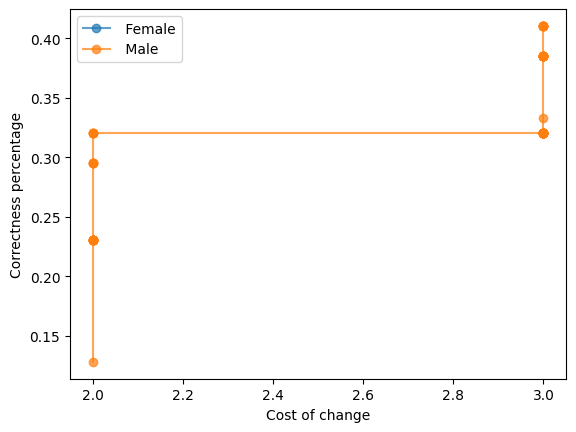

If age = (26.0, 34.0], capital-gain = 0, hours-per-week = FullTime, occupation =  Adm-clerical:
	Protected Subgroup ' Female', 3.45% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.01% covered out of 30527
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Exec-managerial with correctness 49.25%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Exec-managerial with correctness 43.28%.
		Make age = (41.0, 50.0], occupation =  Exec-managerial with correctness 38.81%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with correctness 26.87%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Prof-specialty with correctness 47.76%.
		Make age = (34.0, 41.0], hours-per-week = OverTime, occupation =  Prof-specialty with correctness 38.81%.
		Make age = (41.0, 50.0], hours-per-week = OverTime, occupation =  Sales with correctness 37.31%.
		Make hours-per-week = OverTime, occupation =  Exec-manager

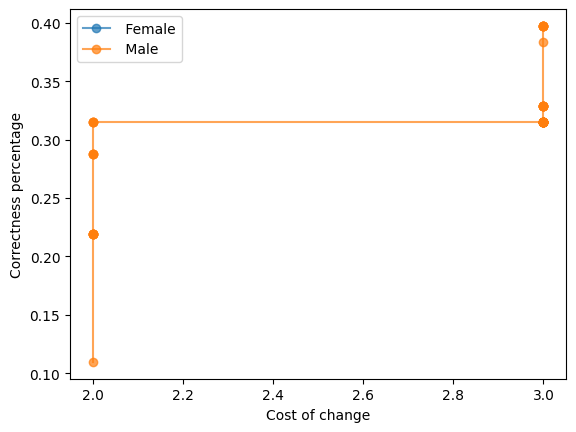

If Workclass =  Private, hours-per-week = FullTime, occupation =  Adm-clerical, race =  White:
	Protected Subgroup ' Female', 9.27% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.22% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 32.43%.
		Make occupation =  Exec-managerial with correctness 23.65%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 28.38%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 20.27%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 32.43%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 28.38%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 37.84%.
		Make hours-per-week = BrainDrain, occupation =  Sales with correctness 20.27%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain

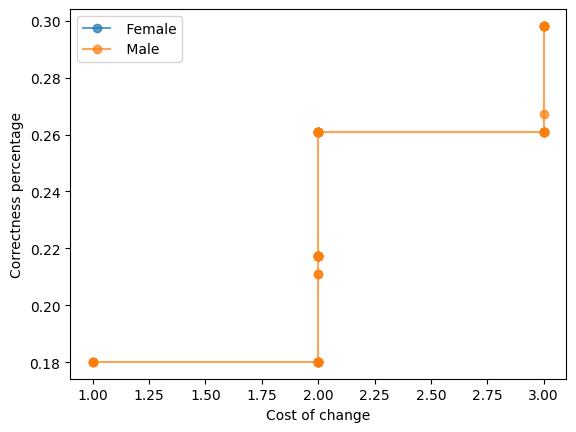

If Workclass =  Private, hours-per-week = FullTime, occupation =  Sales:
	Protected Subgroup ' Female', 4.30% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.96% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 35.53%.
		Make occupation =  Exec-managerial with correctness 23.86%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.47%.
		Make hours-per-week = OverTime with correctness 20.30%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 35.53%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 31.47%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 42.13%.
		Make hours-per-week = BrainDrain with correctness 20.81%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 42.64%.
		Make 

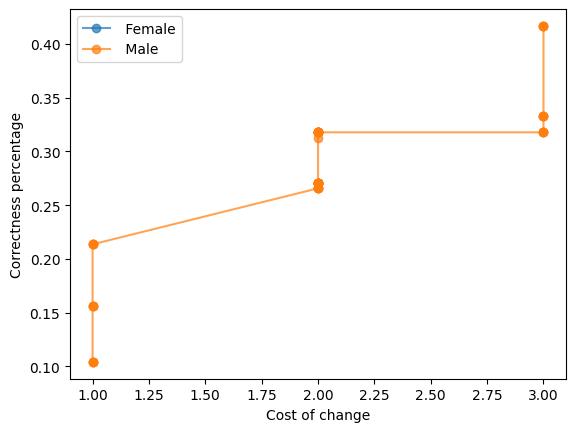

If Workclass =  Private, hours-per-week = FullTime, native-country =  United-States, occupation =  Sales:
	Protected Subgroup ' Female', 3.91% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.82% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 35.11%.
		Make occupation =  Exec-managerial with correctness 25.00%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 31.38%.
		Make hours-per-week = OverTime with correctness 21.28%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 35.11%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 31.38%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 42.02%.
		Make hours-per-week = BrainDrain with correctness 21.81%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain, occupation =  Exec-managerial

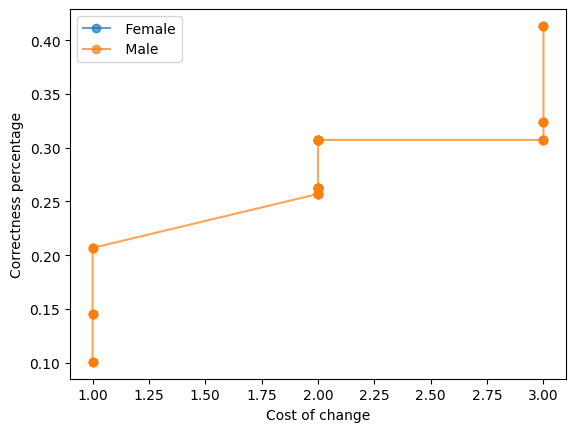

If Workclass =  Private, hours-per-week = FullTime, occupation =  Sales, race =  White:
	Protected Subgroup ' Female', 3.54% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 2.66% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 36.72%.
		Make occupation =  Exec-managerial with correctness 25.42%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 32.77%.
		Make hours-per-week = OverTime with correctness 22.60%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 36.72%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 32.77%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 44.07%.
		Make hours-per-week = BrainDrain with correctness 22.60%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 

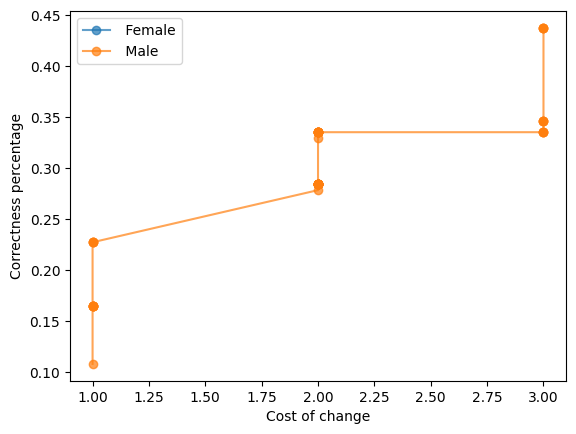

If Workclass =  Private, age = (34.0, 41.0], occupation =  Sales:
	Protected Subgroup ' Female', 1.33% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.10% covered out of 30527
		Make age = (41.0, 50.0], occupation =  Exec-managerial with correctness 46.58%.
		Make age = (50.0, 90.0], occupation =  Exec-managerial with correctness 45.21%.
		Make occupation =  Exec-managerial with correctness 32.88%.
		Make age = (41.0, 50.0], occupation =  Prof-specialty with correctness 35.62%.
		Make occupation =  Prof-specialty with correctness 26.03%.
		Make age = (41.0, 50.0] with correctness 26.03%.
		Make age = (50.0, 90.0], occupation =  Prof-specialty with correctness 32.88%.
		Make Workclass =  Local-gov, age = (41.0, 50.0], occupation =  Prof-specialty with correctness 32.88%.
		Make Workclass =  Self-emp-inc, age = (50.0, 90.0], occupation =  Exec-managerial with correctness 47.95%.
		Make Workclass =  Self-emp-inc, age = (41.0, 50.0], occupation =  Exec

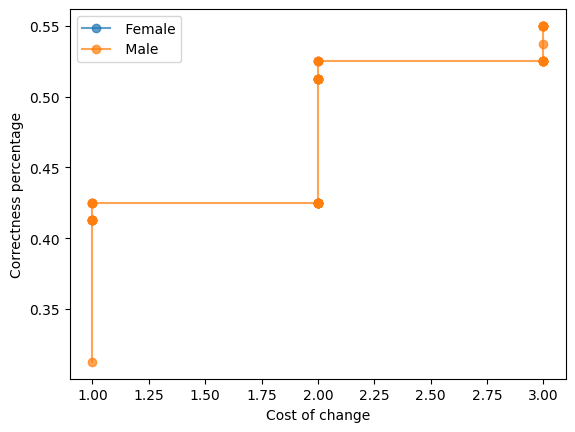

If Workclass =  Private, hours-per-week = FullTime, occupation =  Craft-repair:
	Protected Subgroup ' Female', 1.29% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 11.71% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 39.36%.
		Make occupation =  Exec-managerial with correctness 27.56%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 36.03%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 21.67%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 40.00%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 36.28%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 48.72%.
		Make hours-per-week = BrainDrain, occupation =  Sales with correctness 21.79%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain, occupation =

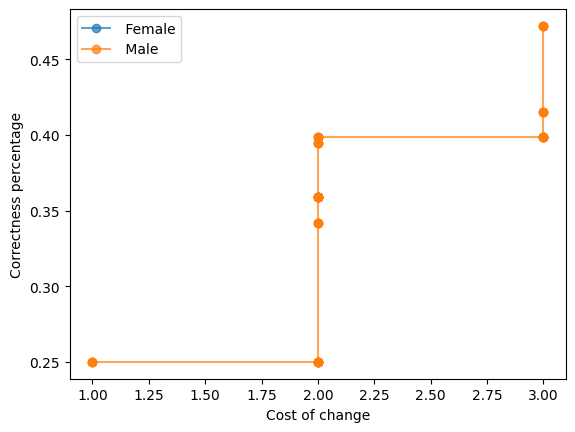

If Workclass =  Private, hours-per-week = FullTime, native-country =  United-States, occupation =  Craft-repair:
	Protected Subgroup ' Female', 1.16% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 10.58% covered out of 30527
		Make hours-per-week = OverTime, occupation =  Exec-managerial with correctness 39.57%.
		Make occupation =  Exec-managerial with correctness 28.37%.
		Make hours-per-week = OverTime, occupation =  Prof-specialty with correctness 36.74%.
		Make hours-per-week = OverTime, occupation =  Sales with correctness 21.99%.
		Make hours-per-week = BrainDrain, occupation =  Exec-managerial with correctness 40.28%.
		Make hours-per-week = BrainDrain, occupation =  Prof-specialty with correctness 36.74%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime, occupation =  Exec-managerial with correctness 49.65%.
		Make hours-per-week = BrainDrain, occupation =  Sales with correctness 21.99%.
		Make Workclass =  Self-emp-inc, hours-pe

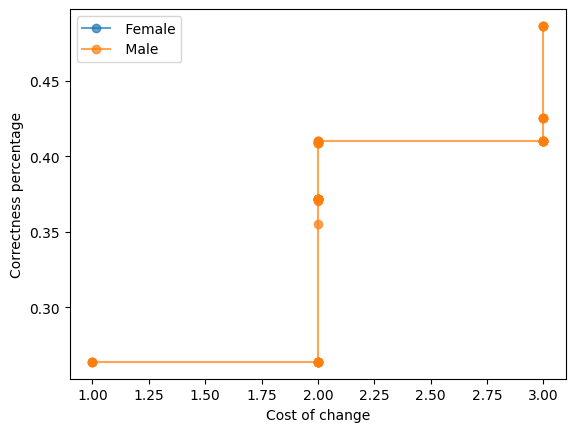

If Workclass =  Self-emp-not-inc, hours-per-week = PartTime:
	Protected Subgroup ' Female', 1.02% covered out of 14695
		Make Workclass =  Federal-gov, hours-per-week = OverTime with correctness 21.43%.
		Make Workclass =  Federal-gov, hours-per-week = OverTime with correctness 21.43%.
		Make Workclass =  Federal-gov, hours-per-week = OverTime with correctness 21.43%.
		Make Workclass =  Federal-gov, hours-per-week = OverTime with correctness 21.43%.
	Protected Subgroup ' Male', 1.40% covered out of 30527
		Make Workclass =  Private, hours-per-week = OverTime with correctness 33.33%.
		Make Workclass =  Private, hours-per-week = FullTime with correctness 26.88%.
		Make Workclass =  Private, hours-per-week = BrainDrain with correctness 34.41%.
		Make Workclass =  Self-emp-inc, hours-per-week = OverTime with correctness 40.86%.
		Make Workclass =  Local-gov, hours-per-week = FullTime with correctness 20.43%.
		Make Workclass =  Self-emp-inc, hours-per-week = BrainDrain with correctness 4

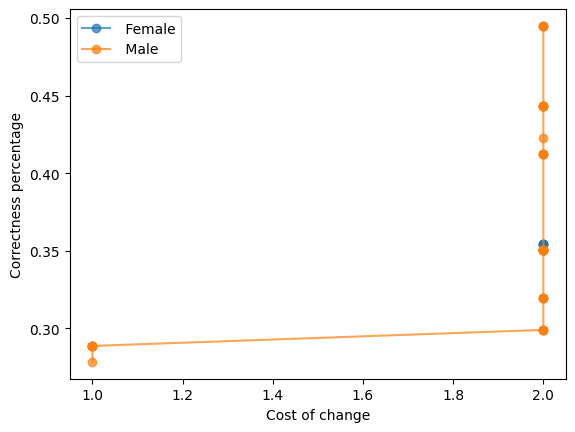

In [38]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.2,
    filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex")

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [ ]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)